# Overview

In [8]:
!pip install torch torchvision seaborn tqdm

You should consider upgrading via the '/Users/leandro/Library/Caches/pypoetry/virtualenvs/whylogs-vWIOXmxX-py3.8/bin/python -m pip install --upgrade pip' command.


----- Train Set
1. Generates embeddings with feature extractor (ImageModel)
2. Normalize embeddings
3. Reduce Dimensionality with PCA for visualization
4. Use labels to get cluster center coordinates of embeddings

----- Test Set
5. Generates embeddings
6. Normalize embeddings
7. Reduce Dimensionality with PCA for visualization
8. Plot histogram of distance of each embedding to cluster centers

The idea is to extract images from 2 different groups: "Horse" vs "Automobile" in order to get the cluster center coordinates from the trainset.

Simulating the production stage, to simulate a data drift, we could:
- Log a batch with only one main category (e.g. "Horse")
- Add an unseen categories in the training phase ("Bird")

And check the histogram of distances to each cluster center to see if there's any difference between the expected distribution (if we had logged images of, and only of, both large land animals and vehicles)


In [9]:
import torch
from tqdm import tqdm
from torch import optim, nn
from torchvision import models, transforms,datasets

# Feature Extractor

In [4]:
class ImageModel(nn.Module):
    def __init__(self, pretrained, nrof_densenet_blocks_retrain, unlock_norms=False):
        super().__init__()
        self.pretrained = pretrained
        self.nrof_densenet_blocks_retrain = nrof_densenet_blocks_retrain
        self.unlock_norms = unlock_norms
        self.net = self.load_image_model()
    def forward(self, images):
        return self.net(images).squeeze(3).squeeze(2)
    def load_image_model(self):
        net = models.densenet121(pretrained=self.pretrained)
        if self.nrof_densenet_blocks_retrain != 5:
            stop_layer = [4, 3, 2, 1, 0, -1][self.nrof_densenet_blocks_retrain]
            for name, param in net.named_parameters():
                if "classifier" in name:
                    continue
                layer = int(name.split(".")[1][-1])
                layer = min(layer, 4)
                if layer <= stop_layer:
                    if not (self.unlock_norms and "norm" in name):
                        param.requires_grad = False
        return nn.Sequential(*(list(net.children())[:-1]) + [nn.AdaptiveAvgPool2d((1,1))])

In [5]:
model = models.densenet121(pretrained=True)
feature_extractor = ImageModel(model,2)

# Dataset

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=preprocess)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                        shuffle=True, num_workers=1)

Files already downloaded and verified


# Train Set

## Generate Features

Let's get 10 batches of 500 images and select only the classes we want. Then we generate the feature embeddings and associated labels from the original dataset.

In [43]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
classes_tokeep = ('automobile','horse','bird', 'cat', 'deer','ship')

# features = torch.empty(0, 1024)
# labels = torch.empty(0)
features = []
labels = []
for i in tqdm(range(15)):
    images, lbs = iter(trainloader).next()
    tuples = [(x,y) for x,y in zip(images,lbs) if classes[y] in classes_tokeep]
    images = torch.stack([x[0] for x in tuples])
    lbs = torch.tensor([x[1] for x in tuples])
    class_labels = [classes[lab] for lab in lbs]

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        new_model.to('cuda')

    with torch.no_grad():
        ft = feature_extractor(images)
    features.extend(ft)
    labels.extend(lbs)
    print(i)


  7%|▋         | 1/15 [00:57<13:21, 57.28s/it]

0


 13%|█▎        | 2/15 [01:50<11:50, 54.64s/it]

1


 20%|██        | 3/15 [02:46<11:06, 55.53s/it]

2


 27%|██▋       | 4/15 [03:36<09:46, 53.35s/it]

3


 33%|███▎      | 5/15 [04:27<08:46, 52.60s/it]

4


 40%|████      | 6/15 [05:19<07:49, 52.12s/it]

5


 47%|████▋     | 7/15 [06:12<07:00, 52.61s/it]

6


 53%|█████▎    | 8/15 [07:06<06:09, 52.84s/it]

7


 60%|██████    | 9/15 [07:57<05:14, 52.35s/it]

8


 67%|██████▋   | 10/15 [08:48<04:19, 51.98s/it]

9


 73%|███████▎  | 11/15 [09:41<03:28, 52.21s/it]

10


 80%|████████  | 12/15 [10:32<02:35, 51.95s/it]

11


 87%|████████▋ | 13/15 [11:22<01:42, 51.36s/it]

12


 93%|█████████▎| 14/15 [12:13<00:51, 51.36s/it]

13


100%|██████████| 15/15 [13:01<00:00, 52.09s/it]

14


In [10]:
# import pickle
# features = []
# labels = []
# with open("features.pkl","wb") as f:
#     pickle.dump(features,f)
    
# with open("labels.pkl","wb") as f:
#     pickle.dump(labels,f)

Let's split the extracted embedding and labels into a train-test

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

features,features_p,labels,labels_p = train_test_split(features,labels)
features = nn.functional.normalize(torch.stack(features), p=2, dim=1)
features_p = nn.functional.normalize(torch.stack(features_p), p=2, dim=1)

## Reduce and Clusterize

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['features'] = features
df['labels'] = [x.item() for x in labels]

df_p = pd.DataFrame()
df_p['features'] = features_p
df_p['labels'] = [x.item() for x in labels_p]

In [13]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
features_np = features.numpy()
pca = PCA(n_components=50)
ft_pca = pca.fit_transform(features_np)

df['pca-one'] = ft_pca[:,0]
df['pca-two'] = ft_pca[:,1] 
df['pca-three'] = ft_pca[:,2]

featuresp_np = features_p.numpy()
ftp_pca = pca.transform(featuresp_np)

df_p['pca-one'] = ftp_pca[:,0]
df_p['pca-two'] = ftp_pca[:,1] 
df_p['pca-three'] = ftp_pca[:,2]


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Let's plot the firt 2 components and annotate the location of each center:

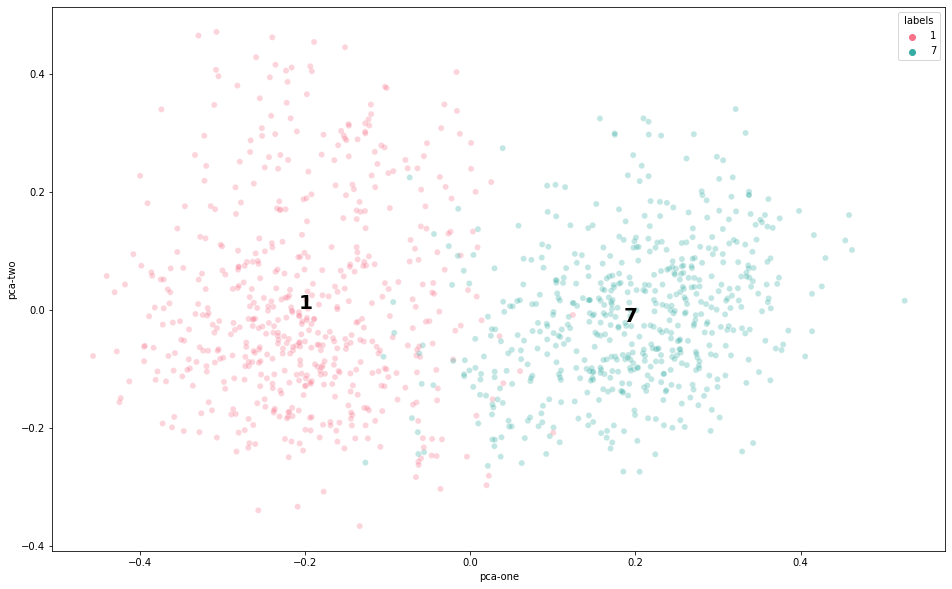

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    palette=sns.color_palette("husl", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in [1,7]:
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Let's see if the points from the test set behave the way we expect to:

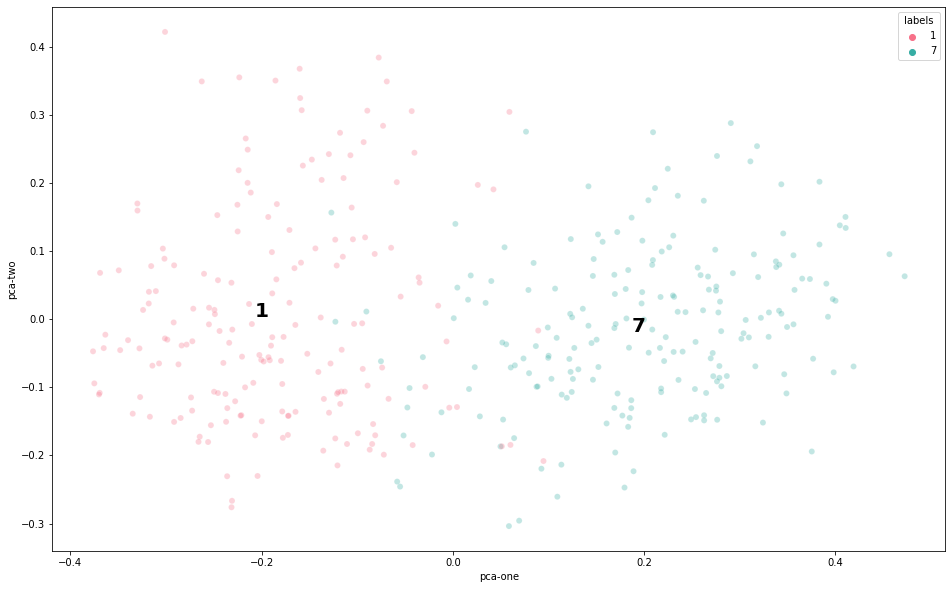

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df_p.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    palette=sns.color_palette("husl", 2),
    data=df_p.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in [1,7]:
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Simulating a scenario where we only have images from one category:

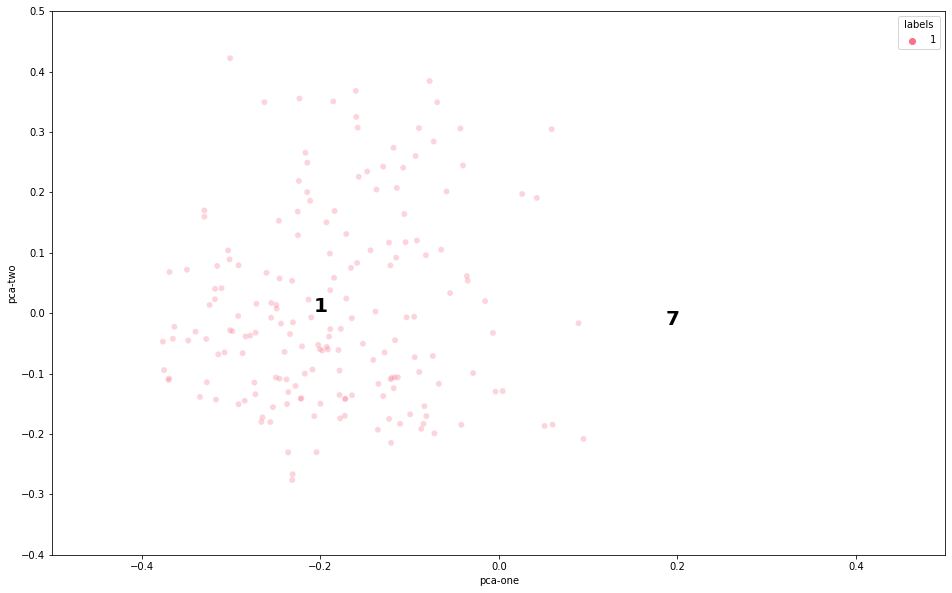

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df_p.shape[0])

plt.figure(figsize=(16,10))
plt.xlim([-0.5, 0.5])
plt.ylim([-0.4, 0.5])
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    palette=sns.color_palette("husl", 1),
    data=df_p[df_p['labels']==1],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in [1,7]:
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

# Production Stage

## Case 1 - Batch with only one group

Calculating the coordinates for centers of both groups `c1` and `c7`

In [29]:
features_1 = torch.stack([x for i,x in enumerate(features) if labels[i]==1 ])
c1 = torch.mean(features_1,0)
c1.size()

torch.Size([1024])

In [30]:
features_7 = torch.stack([x for i,x in enumerate(features) if labels[i]==7 ])
c7 = torch.mean(features_7,0)
c7.size()

torch.Size([1024])

Calculating the distance (dot product) between each embedding in the test set and centers of both categories:

In [33]:
# Distances between train set and cluster centers
dist_1 = [torch.dot(x,c1).item() for x in features]
dist_7 = [torch.dot(x,c7).item() for x in features]

# dist_1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]

# Distances between test set, with only one category "Horse", and cluster centers
dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p) if labels_p[i]==7]
dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p) if labels_p[i]==7]

# dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]


[0.17042507231235504,
 0.2129431962966919,
 0.22449064254760742,
 0.19598861038684845,
 0.13641376793384552,
 0.24507813155651093,
 0.27109554409980774,
 0.29645904898643494,
 0.25392580032348633,
 0.2755275368690491,
 0.2529647946357727,
 0.24741485714912415,
 0.30369818210601807,
 0.28904691338539124,
 0.307974636554718,
 0.19186410307884216,
 0.17146170139312744,
 0.17493374645709991,
 0.2829854488372803,
 0.32672762870788574,
 0.11368265002965927,
 0.21547073125839233,
 0.2925056219100952,
 0.29045313596725464,
 0.20046353340148926,
 0.18512819707393646,
 0.2699890732765198,
 0.16407379508018494,
 0.21265588700771332,
 0.27566927671432495,
 0.1452510952949524,
 0.23555594682693481,
 0.255568265914917,
 0.2698711156845093,
 0.1794980764389038,
 0.28451433777809143,
 0.25903356075286865,
 0.2590813934803009,
 0.27680379152297974,
 0.23209208250045776,
 0.15620943903923035,
 0.29912906885147095,
 0.2751310169696808,
 0.1759127378463745,
 0.14074420928955078,
 0.16620147228240967,
 0.1

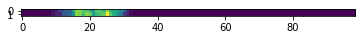

In [42]:
linear_bins=np.linspace(0,1,100)
counts_1, bins=np.histogram(dist_1,linear_bins)
counts_7, bins=np.histogram(dist_7,linear_bins)

plt.imshow(np.array([counts_1,counts_7]))
plt.show()

Plotting Histograms:
    - Train set x Cluster Center 1
    - Test set x Cluster Center 1
    - Train set x Cluster Center 7
    - Teste set x Cluster Center 7

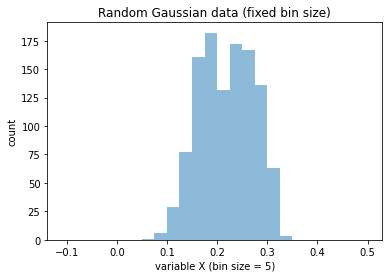

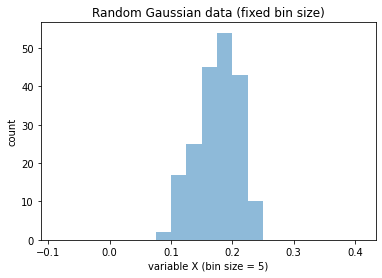

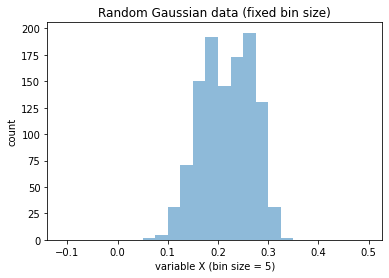

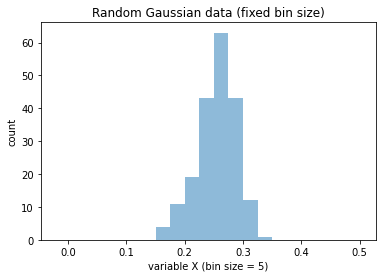

In [21]:
import numpy as np
import random
from matplotlib import pyplot as plt
dists = [dist_1,dist_p1,dist_7,dist_p7]
# fixed bin size
for dist_n in dists:
    bins = np.arange(0, 1, 0.025) # fixed bin size

    plt.xlim([min(dist_n)-0.2, max(dist_n)+0.2])

    plt.plot(dist_n, bins=bins, alpha=0.5)
    plt.title('')
    plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')

    plt.show()